In [49]:
import torch
from torch import nn
import matplotlib.pyplot as plt

import os
import pandas as pd

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [50]:
file_path = "./IMBD.csv"

In [51]:
imdb = pd.read_csv(file_path)

In [52]:
imdb.head()

,title,year,certificate,duration,genre,rating,description,stars,votes
0,Cobra Kai,(2018– ),TV-14,30 min,"Action, Comedy, Drama",8.5,Decades after their 1984 All Valley Karate Tou...,"['Ralph Macchio, ', 'William Zabka, ', 'Courtn...","177,031"
1,The Crown,(2016– ),TV-MA,58 min,"Biography, Drama, History",8.7,Follows the political rivalries and romance of...,"['Claire Foy, ', 'Olivia Colman, ', 'Imelda St...","199,885"
2,Better Call Saul,(2015–2022),TV-MA,46 min,"Crime, Drama",8.9,The trials and tribulations of criminal lawyer...,"['Bob Odenkirk, ', 'Rhea Seehorn, ', 'Jonathan...","501,384"
3,Devil in Ohio,(2022),TV-MA,356 min,"Drama, Horror, Mystery",5.9,When a psychiatrist shelters a mysterious cult...,"['Emily Deschanel, ', 'Sam Jaeger, ', 'Gerardo...","9,773"
4,Cyberpunk: Edgerunners,(2022– ),TV-MA,24 min,"Animation, Action, Adventure",8.6,A Street Kid trying to survive in a technology...,"['Zach Aguilar, ', 'Kenichiro Ohashi, ', 'Emi ...","15,413"


In [53]:
imdb['genre'] = imdb['genre'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
imdb['rating'] = imdb['rating'].apply(lambda x: x if isinstance(x, float) else 6.53)

#turn genre into a list of genres

In [54]:
first_movie_genres = imdb.loc[10, 'rating']
first_movie_genres


8.7

In [55]:
#for index, row in imdb_df.iterrows():
   # if type(imdb.at[index, 'genre']) == 'float':
  #      print(imdb.at[index, 'genre'])
  #  else:
   #     imdb.at[index, 'genre'] = imdb.iloc[index]['genre'].split(', ')
   # print(imdb.at[index, 'genre'])
    

In [56]:
mlb = MultiLabelBinarizer()


In [57]:
genres_encoded = mlb.fit_transform(imdb['genre'])
#make the tensors

genre_tensor = torch.tensor(genres_encoded, dtype=torch.float32)
rating_tensor = torch.tensor(imdb['rating'].values, dtype=torch.float32)

In [58]:
nan_indices = torch.isnan(rating_tensor)
mean_rating = torch.mean(rating_tensor[~nan_indices])
rating_tensor[nan_indices] = mean_rating
rating_tensor = rating_tensor.float()


In [59]:
split = int(len(imdb) * 0.8)
#genre is x, and rating is y
genre_train, rating_train = genre_tensor[:split], rating_tensor[:split]
genre_test, rating_test = genre_tensor[split:], rating_tensor[split:]

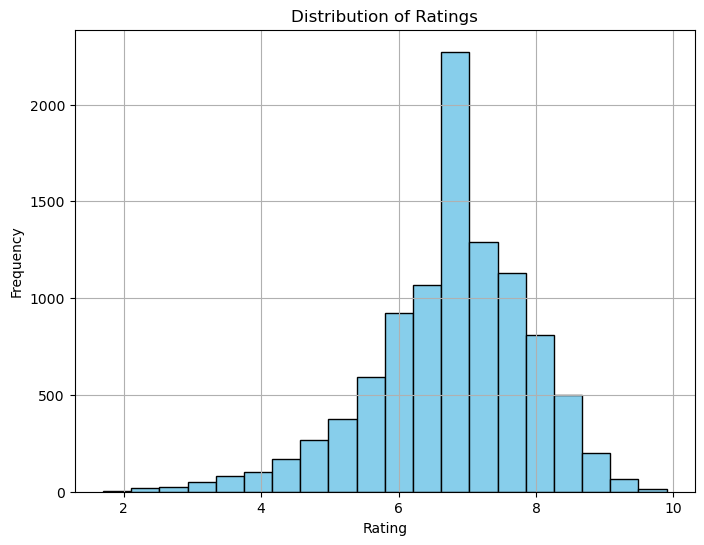

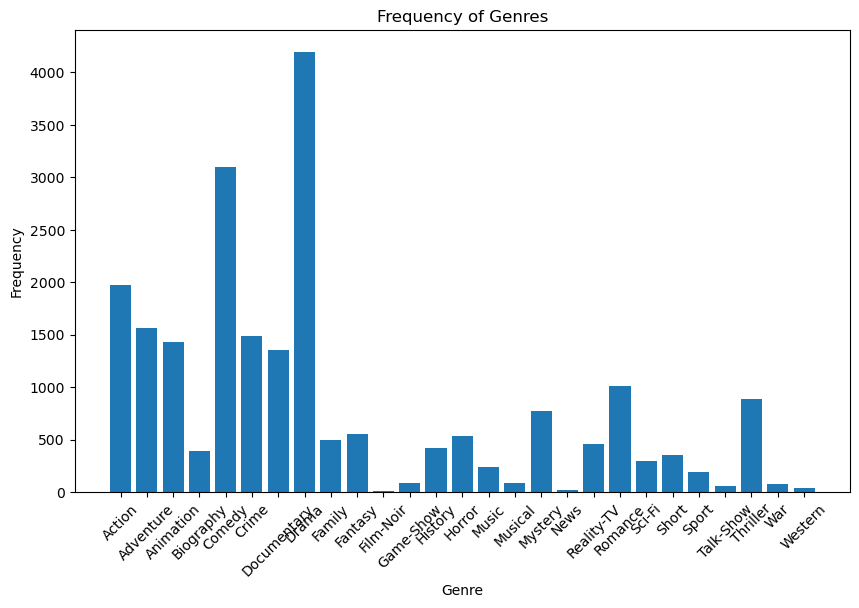

In [60]:
plt.figure(figsize=(8, 6))
plt.hist(rating_tensor, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.grid(True)
plt.show()

# Bar plot of genre frequencies
genre_counts = genre_tensor.sum(dim=0)  # Sum across rows to get genre frequencies
genres = mlb.classes_

plt.figure(figsize=(10, 6))
plt.bar(genres, genre_counts)
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.title('Frequency of Genres')
plt.xticks(rotation=45)
plt.show()

In [61]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=genre_train.shape[1] , out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
        
        

In [62]:
model = LinearRegressionModel()
model, model.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=27, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight',
               tensor([[ 0.1093, -0.0822,  0.0494,  0.0269,  0.1476, -0.0134, -0.0309, -0.0894,
                         0.1681, -0.1228,  0.1560,  0.0265, -0.0574, -0.0652, -0.0638,  0.1912,
                        -0.1700, -0.1139, -0.0014,  0.1784,  0.0134,  0.1065, -0.1737,  0.0903,
                         0.0124, -0.1102, -0.0116]])),
              ('linear_layer.bias', tensor([0.1355]))]))

In [63]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [64]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [65]:
epochs = 1000

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    rating_pred = model(genre_train)

    # Ensure rating_pred is squeezed to (batch_size,)
    rating_pred = rating_pred.squeeze()

    # Calculate loss
    loss = loss_fn(rating_pred, rating_train)

    # Backward pass and optimization step
    loss.backward()
    optimizer.step()

    # Evaluation on test set
    model.eval()
    with torch.no_grad():
        test_pred = model(genre_test).squeeze()
        test_loss = loss_fn(test_pred, rating_test)

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}], Train Loss: {loss.item()}, Test Loss: {test_loss.item()}")

Epoch [0/1000], Train Loss: 6.400641918182373, Test Loss: 7.420934677124023
Epoch [100/1000], Train Loss: 4.99105167388916, Test Loss: 5.941415309906006
Epoch [200/1000], Train Loss: 3.591156244277954, Test Loss: 4.467263221740723
Epoch [300/1000], Train Loss: 2.3116159439086914, Test Loss: 3.0609798431396484
Epoch [400/1000], Train Loss: 1.4805083274841309, Test Loss: 1.9604315757751465
Epoch [500/1000], Train Loss: 1.17079758644104, Test Loss: 1.380357265472412
Epoch [600/1000], Train Loss: 1.0733177661895752, Test Loss: 1.154860496520996
Epoch [700/1000], Train Loss: 1.0263161659240723, Test Loss: 1.0592845678329468
Epoch [800/1000], Train Loss: 0.9924334287643433, Test Loss: 1.0095521211624146
Epoch [900/1000], Train Loss: 0.9654154777526855, Test Loss: 0.9909319877624512


In [76]:
imdb['genre']

0              [Action, Comedy, Drama]
1          [Biography, Drama, History]
2                       [Crime, Drama]
3             [Drama, Horror, Mystery]
4       [Animation, Action, Adventure]
                     ...              
9952        [Action, Adventure, Drama]
9953         [Drama, Horror, Thriller]
9954       [Biography, Drama, History]
9955          [Drama, Fantasy, Horror]
9956          [Drama, Horror, Mystery]
Name: genre, Length: 9957, dtype: object

In [90]:
test_genres = ['Animation', 'Action', 'Adventure']
test_genres_encoded = mlb.transform([test_genres])
test_genres_tensor = torch.tensor(test_genres_encoded, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    predicted_rating = model(test_genres_tensor).item()
predicted_rating

6.7647905349731445

In [91]:
predicted_rating

6.7647905349731445